In [1]:
import os
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import random
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
from tqdm import tqdm

import torch.nn as nn
import torch.optim as optim
import torchvision.models as models

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, classification_report
import seaborn as sns



In [2]:
H, W = 224, 224
BATCH_SIZE = 32
EPOCH = 50

In [3]:
image_paths = []
image_labels = []
normal_count = scc_count = 0

for dirname, _, filenames in os.walk('/kaggle/input/multi-cancer/Multi Cancer/Multi Cancer/Oral Cancer/'):
    for filename in filenames:
        if "bak" in filename: continue    #Ignore all images ending with .bak
        path = os.path.join(dirname, filename)
        image_paths.append(path)
        if 'normal' in filename:
            image_labels.append(0)
            normal_count += 1
        else:
            image_labels.append(1)
            scc_count += 1

#Shuffle
combined = list(zip(image_paths, image_labels))
random.shuffle(combined)
image_paths, image_labels = zip(*combined)
image_paths = list(image_paths)
image_labels = list(image_labels)

print(image_paths[:5], '\n')
print(image_labels[:5], '\n')
print("Image count:", len(image_paths))
print("Normal count:", normal_count)
print("SCC count:", scc_count)
print("Image size:", Image.open(image_paths[0]).size)
print("Image mode:", Image.open(image_paths[0]).mode)

['/kaggle/input/multi-cancer/Multi Cancer/Multi Cancer/Oral Cancer/oral_normal/oral_normal_0932.jpg', '/kaggle/input/multi-cancer/Multi Cancer/Multi Cancer/Oral Cancer/oral_scc/oral_scc_4887.jpg', '/kaggle/input/multi-cancer/Multi Cancer/Multi Cancer/Oral Cancer/oral_normal/oral_normal_3884.jpg', '/kaggle/input/multi-cancer/Multi Cancer/Multi Cancer/Oral Cancer/oral_scc/oral_scc_3826.jpg', '/kaggle/input/multi-cancer/Multi Cancer/Multi Cancer/Oral Cancer/oral_normal/oral_normal_0516.jpg'] 

[0, 1, 0, 1, 0] 

Image count: 10000
Normal count: 5000
SCC count: 5000
Image size: (512, 512)
Image mode: RGB


In [4]:
#train, val, test = 70%, 15%, 15%
train_paths, temp_paths, train_labels, temp_labels = train_test_split(image_paths, image_labels, test_size=0.3, stratify=image_labels)
val_paths, test_paths, val_labels, test_labels = train_test_split(temp_paths, temp_labels, test_size=0.5, stratify=temp_labels)

print("Training size:", len(train_paths))
print("Validation size:", len(val_paths))
print("Testing size:", len(test_paths))

Training size: 7000
Validation size: 1500
Testing size: 1500


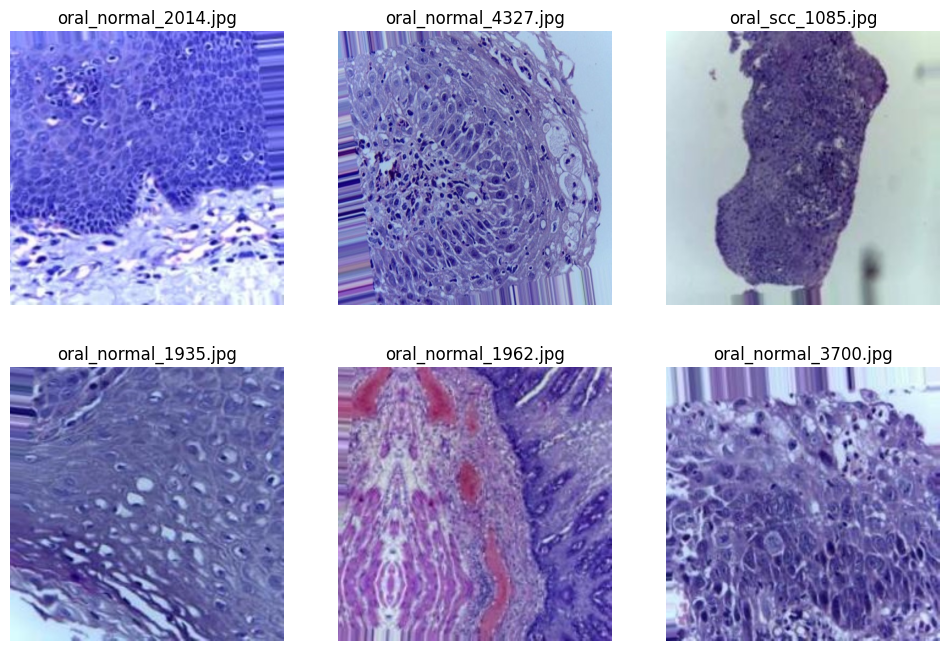

In [5]:
sample_images = random.sample(train_paths, 6)
plt.figure(figsize=(12, 8))

for i, img_path in enumerate(sample_images):
    img = Image.open(img_path)
    plt.subplot(2, 3, i + 1)
    plt.imshow(img)
    plt.title(os.path.basename(img_path), fontsize=12)
    plt.axis('off')

plt.show()

In [6]:
# Calculate Mean and Standard Deviation of the training set
transform = transforms.Compose([
    transforms.Resize((H, W)),
    transforms.ToTensor()
])

mean = 0.
std = 0.
n = 0

for path in tqdm(train_paths):
    img = Image.open(path).convert('RGB')
    img = transform(img)  # shape: [3, H, W]
    mean += img.mean(dim=[1,2])
    std += img.std(dim=[1,2])
    n += 1

mean /= n
std /= n

print("Mean:", mean)
print("Std:", std)

100%|██████████| 7000/7000 [01:24<00:00, 83.19it/s]


Mean: tensor([0.5541, 0.5152, 0.7294])
Std: tensor([0.1621, 0.1930, 0.1225])


In [7]:
#Data augmentation 
train_transform = transforms.Compose([
    transforms.Resize((H, W)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean.tolist(), std=std.tolist())
])

val_transform = transforms.Compose([
    transforms.Resize((H, W)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean.tolist(), std=std.tolist())
])

test_transform = transforms.Compose([
    transforms.Resize((H, W)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean.tolist(), std=std.tolist())
])

In [8]:
class ImageDataset(Dataset):
    def __init__(self, image_paths, image_labels, transform=None):
        self.image_paths = image_paths
        self.labels = image_labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

# For train_loader, val_loader and test_loader
# There are approximately len({}_paths) / BATCH_SIZE batches in total
# Each batch has a shape of [BATCH_SIZE, 3, H, W]
train_dataset = ImageDataset(train_paths, train_labels, transform=train_transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True) 

val_dataset = ImageDataset(val_paths, val_labels, transform=val_transform)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True) 

test_dataset = ImageDataset(test_paths, test_labels, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [9]:
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models

In [10]:

EPOCH = 25                 # 第一階段的 Epoch 數量

best_model_path = "best_oral_cancer_model.pth"

# 設置 GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


print("Loading ResNet50 model...")
model = models.resnet50(pretrained=True)

# 凍結所有層
for param in model.parameters():
    param.requires_grad = False

# 最後的分類層
num_features = model.fc.in_features 
model.fc = nn.Linear(num_features, 2) # (normal, scc)

model = model.to(device)

# --- Training ---
print("\n--- Training  ---")

criterion = nn.CrossEntropyLoss()

# 優化器 
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

best_val_acc = 0.0

for epoch in range(EPOCH):
    model.train() 
    train_loss = 0.0
    train_corrects = 0
    train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCH} [Phase 1 Train]")
    
    for inputs, labels in train_pbar:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        train_corrects += torch.sum(preds == labels.data)
        train_pbar.set_postfix({'loss': loss.item()})

    epoch_train_loss = train_loss / len(train_dataset)
    epoch_train_acc = train_corrects.double() / len(train_dataset)

    model.eval() 
    val_loss = 0.0
    val_corrects = 0
    with torch.no_grad():
        val_pbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCH} [Phase 1 Val]")
        for inputs, labels in val_pbar:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            val_corrects += torch.sum(preds == labels.data)
            val_pbar.set_postfix({'loss': loss.item()})

    epoch_val_loss = val_loss / len(val_dataset)
    epoch_val_acc = val_corrects.double() / len(val_dataset)

    # 🔥 [新增] 將數據存入 history (.item() 將 tensor 轉為數值)
    history['train_loss'].append(epoch_train_loss)
    history['train_acc'].append(epoch_train_acc.item())
    history['val_loss'].append(epoch_val_loss)
    history['val_acc'].append(epoch_val_acc.item())

    print(f"Phase 1 Epoch {epoch+1}/{EPOCH} | Train Loss: {epoch_train_loss:.4f} Acc: {epoch_train_acc:.4f} | Val Loss: {epoch_val_loss:.4f} Acc: {epoch_val_acc:.4f}")
    
    if epoch_val_acc > best_val_acc:
        best_val_acc = epoch_val_acc
        torch.save(model.state_dict(), best_model_path)
        print(f"New best model saved to {best_model_path} with Val Acc: {best_val_acc:.4f}")
        
print("finished.")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Using device: cuda
Loading ResNet50 model...


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 197MB/s] 



--- Training  ---


Epoch 1/25 [Phase 1 Val]: 100%|██████████| 47/47 [00:21<00:00,  2.15it/s, loss=0.55] 


Phase 1 Epoch 1/25 | Train Loss: 0.5246 Acc: 0.7350 | Val Loss: 0.4789 Acc: 0.7600
New best model saved to best_oral_cancer_model.pth with Val Acc: 0.7600


Epoch 2/25 [Phase 1 Val]: 100%|██████████| 47/47 [00:13<00:00,  3.61it/s, loss=0.366]


Phase 1 Epoch 2/25 | Train Loss: 0.4580 Acc: 0.7800 | Val Loss: 0.4203 Acc: 0.7980
New best model saved to best_oral_cancer_model.pth with Val Acc: 0.7980


Epoch 3/25 [Phase 1 Val]: 100%|██████████| 47/47 [00:13<00:00,  3.45it/s, loss=0.355]


Phase 1 Epoch 3/25 | Train Loss: 0.4460 Acc: 0.7899 | Val Loss: 0.5238 Acc: 0.7647


Epoch 4/25 [Phase 1 Val]: 100%|██████████| 47/47 [00:13<00:00,  3.55it/s, loss=0.31] 


Phase 1 Epoch 4/25 | Train Loss: 0.4382 Acc: 0.7960 | Val Loss: 0.3971 Acc: 0.8240
New best model saved to best_oral_cancer_model.pth with Val Acc: 0.8240


Epoch 5/25 [Phase 1 Val]: 100%|██████████| 47/47 [00:13<00:00,  3.61it/s, loss=0.593]


Phase 1 Epoch 5/25 | Train Loss: 0.4171 Acc: 0.8067 | Val Loss: 0.3848 Acc: 0.8253
New best model saved to best_oral_cancer_model.pth with Val Acc: 0.8253


Epoch 6/25 [Phase 1 Val]: 100%|██████████| 47/47 [00:12<00:00,  3.62it/s, loss=0.255]


Phase 1 Epoch 6/25 | Train Loss: 0.4238 Acc: 0.8079 | Val Loss: 0.5099 Acc: 0.7527


Epoch 7/25 [Phase 1 Val]: 100%|██████████| 47/47 [00:13<00:00,  3.61it/s, loss=0.489]


Phase 1 Epoch 7/25 | Train Loss: 0.4166 Acc: 0.8083 | Val Loss: 0.3831 Acc: 0.8273
New best model saved to best_oral_cancer_model.pth with Val Acc: 0.8273


Epoch 8/25 [Phase 1 Val]: 100%|██████████| 47/47 [00:13<00:00,  3.47it/s, loss=0.659]


Phase 1 Epoch 8/25 | Train Loss: 0.4027 Acc: 0.8180 | Val Loss: 0.4600 Acc: 0.7907


Epoch 9/25 [Phase 1 Val]: 100%|██████████| 47/47 [00:13<00:00,  3.59it/s, loss=0.492]


Phase 1 Epoch 9/25 | Train Loss: 0.4037 Acc: 0.8186 | Val Loss: 0.3613 Acc: 0.8320
New best model saved to best_oral_cancer_model.pth with Val Acc: 0.8320


Epoch 10/25 [Phase 1 Val]: 100%|██████████| 47/47 [00:12<00:00,  3.66it/s, loss=0.49] 


Phase 1 Epoch 10/25 | Train Loss: 0.4107 Acc: 0.8143 | Val Loss: 0.4145 Acc: 0.8020


Epoch 11/25 [Phase 1 Val]: 100%|██████████| 47/47 [00:13<00:00,  3.55it/s, loss=0.296]


Phase 1 Epoch 11/25 | Train Loss: 0.4189 Acc: 0.8110 | Val Loss: 0.3545 Acc: 0.8400
New best model saved to best_oral_cancer_model.pth with Val Acc: 0.8400


Epoch 12/25 [Phase 1 Val]: 100%|██████████| 47/47 [00:12<00:00,  3.68it/s, loss=0.254]


Phase 1 Epoch 12/25 | Train Loss: 0.3927 Acc: 0.8181 | Val Loss: 0.3539 Acc: 0.8413
New best model saved to best_oral_cancer_model.pth with Val Acc: 0.8413


Epoch 13/25 [Phase 1 Val]: 100%|██████████| 47/47 [00:12<00:00,  3.63it/s, loss=0.285]


Phase 1 Epoch 13/25 | Train Loss: 0.3682 Acc: 0.8411 | Val Loss: 0.3537 Acc: 0.8407


Epoch 14/25 [Phase 1 Val]: 100%|██████████| 47/47 [00:12<00:00,  3.67it/s, loss=0.328]


Phase 1 Epoch 14/25 | Train Loss: 0.3802 Acc: 0.8283 | Val Loss: 0.3613 Acc: 0.8413


Epoch 15/25 [Phase 1 Val]: 100%|██████████| 47/47 [00:12<00:00,  3.66it/s, loss=0.298]


Phase 1 Epoch 15/25 | Train Loss: 0.3852 Acc: 0.8294 | Val Loss: 0.3491 Acc: 0.8393


Epoch 16/25 [Phase 1 Val]: 100%|██████████| 47/47 [00:13<00:00,  3.60it/s, loss=0.366]


Phase 1 Epoch 16/25 | Train Loss: 0.3859 Acc: 0.8273 | Val Loss: 0.3388 Acc: 0.8513
New best model saved to best_oral_cancer_model.pth with Val Acc: 0.8513


Epoch 17/25 [Phase 1 Val]: 100%|██████████| 47/47 [00:12<00:00,  3.68it/s, loss=0.489]


Phase 1 Epoch 17/25 | Train Loss: 0.3752 Acc: 0.8301 | Val Loss: 0.3503 Acc: 0.8447


Epoch 18/25 [Phase 1 Val]: 100%|██████████| 47/47 [00:12<00:00,  3.62it/s, loss=0.339]


Phase 1 Epoch 18/25 | Train Loss: 0.3622 Acc: 0.8417 | Val Loss: 0.3495 Acc: 0.8507


Epoch 19/25 [Phase 1 Val]: 100%|██████████| 47/47 [00:13<00:00,  3.61it/s, loss=0.409]


Phase 1 Epoch 19/25 | Train Loss: 0.3708 Acc: 0.8313 | Val Loss: 0.3562 Acc: 0.8427


Epoch 20/25 [Phase 1 Val]: 100%|██████████| 47/47 [00:12<00:00,  3.67it/s, loss=0.458]


Phase 1 Epoch 20/25 | Train Loss: 0.3663 Acc: 0.8376 | Val Loss: 0.3496 Acc: 0.8427


Epoch 21/25 [Phase 1 Val]: 100%|██████████| 47/47 [00:12<00:00,  3.63it/s, loss=0.501]


Phase 1 Epoch 21/25 | Train Loss: 0.3658 Acc: 0.8379 | Val Loss: 0.3393 Acc: 0.8480


Epoch 22/25 [Phase 1 Val]: 100%|██████████| 47/47 [00:12<00:00,  3.69it/s, loss=0.438]


Phase 1 Epoch 22/25 | Train Loss: 0.3652 Acc: 0.8361 | Val Loss: 0.3690 Acc: 0.8273


Epoch 23/25 [Phase 1 Val]: 100%|██████████| 47/47 [00:12<00:00,  3.66it/s, loss=0.362]


Phase 1 Epoch 23/25 | Train Loss: 0.3738 Acc: 0.8286 | Val Loss: 0.3329 Acc: 0.8453


Epoch 24/25 [Phase 1 Val]: 100%|██████████| 47/47 [00:12<00:00,  3.65it/s, loss=0.249]


Phase 1 Epoch 24/25 | Train Loss: 0.3661 Acc: 0.8369 | Val Loss: 0.3254 Acc: 0.8540
New best model saved to best_oral_cancer_model.pth with Val Acc: 0.8540


Epoch 25/25 [Phase 1 Val]: 100%|██████████| 47/47 [00:13<00:00,  3.60it/s, loss=0.527]

Phase 1 Epoch 25/25 | Train Loss: 0.3659 Acc: 0.8363 | Val Loss: 0.3275 Acc: 0.8533
finished.


In [11]:
# 模型微調 
print("\n--- Fine-Tuning ---")

NUM_FINETUNE_EPOCHS = 20   # 第二階段的 Epoch 數量

# 載入第一階段的最佳模型
model.load_state_dict(torch.load(best_model_path))
print(f"Loaded best model from Phase 1 with Val Acc: {best_val_acc:.4f}")

# 解凍所有層
for param in model.parameters():
    param.requires_grad = True

# 優化器
optimizer = optim.Adam(model.parameters(), lr=1e-5) # 學習率 0.00001

best_finetune_acc = best_val_acc 

for epoch in range(NUM_FINETUNE_EPOCHS):
    model.train()
    train_loss = 0.0
    train_corrects = 0
    train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_FINETUNE_EPOCHS} [Phase 2 Train]")
    
    for inputs, labels in train_pbar:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        train_corrects += torch.sum(preds == labels.data)
        train_pbar.set_postfix({'loss': loss.item()})

    epoch_train_loss = train_loss / len(train_dataset)
    epoch_train_acc = train_corrects.double() / len(train_dataset)

    model.eval()
    val_loss = 0.0
    val_corrects = 0
    with torch.no_grad():
        val_pbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{NUM_FINETUNE_EPOCHS} [Phase 2 Val]")
        for inputs, labels in val_pbar:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            val_corrects += torch.sum(preds == labels.data)
            val_pbar.set_postfix({'loss': loss.item()})

    epoch_val_loss = val_loss / len(val_dataset)
    epoch_val_acc = val_corrects.double() / len(val_dataset)

    # 🔥 [新增] 繼續將數據存入同一個 history (接續 Phase 1)
    history['train_loss'].append(epoch_train_loss)
    history['train_acc'].append(epoch_train_acc.item())
    history['val_loss'].append(epoch_val_loss)
    history['val_acc'].append(epoch_val_acc.item())

    print(f"Phase 2 Epoch {epoch+1}/{NUM_FINETUNE_EPOCHS} | Train Loss: {epoch_train_loss:.4f} Acc: {epoch_train_acc:.4f} | Val Loss: {epoch_val_loss:.4f} Acc: {epoch_val_acc:.4f}")
    
    if epoch_val_acc > best_finetune_acc:
        best_finetune_acc = epoch_val_acc
        torch.save(model.state_dict(), best_model_path)
        print(f"New BEST model saved (Fine-Tuning) to {best_model_path} with Val Acc: {best_finetune_acc:.4f}")

print(" Fine-tuning finished.")




--- Fine-Tuning ---
Loaded best model from Phase 1 with Val Acc: 0.8540


Epoch 1/20 [Phase 2 Val]: 100%|██████████| 47/47 [00:12<00:00,  3.66it/s, loss=0.306] 


Phase 2 Epoch 1/20 | Train Loss: 0.2810 Acc: 0.8810 | Val Loss: 0.2170 Acc: 0.9087
New BEST model saved (Fine-Tuning) to best_oral_cancer_model.pth with Val Acc: 0.9087


Epoch 2/20 [Phase 2 Val]: 100%|██████████| 47/47 [00:12<00:00,  3.64it/s, loss=0.193] 


Phase 2 Epoch 2/20 | Train Loss: 0.1759 Acc: 0.9323 | Val Loss: 0.1525 Acc: 0.9300
New BEST model saved (Fine-Tuning) to best_oral_cancer_model.pth with Val Acc: 0.9300


Epoch 3/20 [Phase 2 Val]: 100%|██████████| 47/47 [00:13<00:00,  3.57it/s, loss=0.078] 


Phase 2 Epoch 3/20 | Train Loss: 0.1272 Acc: 0.9516 | Val Loss: 0.1115 Acc: 0.9513
New BEST model saved (Fine-Tuning) to best_oral_cancer_model.pth with Val Acc: 0.9513


Epoch 4/20 [Phase 2 Val]: 100%|██████████| 47/47 [00:12<00:00,  3.71it/s, loss=0.023] 


Phase 2 Epoch 4/20 | Train Loss: 0.0989 Acc: 0.9630 | Val Loss: 0.0888 Acc: 0.9593
New BEST model saved (Fine-Tuning) to best_oral_cancer_model.pth with Val Acc: 0.9593


Epoch 5/20 [Phase 2 Val]: 100%|██████████| 47/47 [00:12<00:00,  3.62it/s, loss=0.00573]


Phase 2 Epoch 5/20 | Train Loss: 0.0785 Acc: 0.9706 | Val Loss: 0.0663 Acc: 0.9707
New BEST model saved (Fine-Tuning) to best_oral_cancer_model.pth with Val Acc: 0.9707


Epoch 6/20 [Phase 2 Val]: 100%|██████████| 47/47 [00:12<00:00,  3.66it/s, loss=0.0275] 


Phase 2 Epoch 6/20 | Train Loss: 0.0679 Acc: 0.9744 | Val Loss: 0.0636 Acc: 0.9727
New BEST model saved (Fine-Tuning) to best_oral_cancer_model.pth with Val Acc: 0.9727


Epoch 7/20 [Phase 2 Val]: 100%|██████████| 47/47 [00:13<00:00,  3.56it/s, loss=0.141]  


Phase 2 Epoch 7/20 | Train Loss: 0.0573 Acc: 0.9759 | Val Loss: 0.0582 Acc: 0.9733
New BEST model saved (Fine-Tuning) to best_oral_cancer_model.pth with Val Acc: 0.9733


Epoch 8/20 [Phase 2 Val]: 100%|██████████| 47/47 [00:13<00:00,  3.51it/s, loss=0.0202]  


Phase 2 Epoch 8/20 | Train Loss: 0.0482 Acc: 0.9803 | Val Loss: 0.0487 Acc: 0.9780
New BEST model saved (Fine-Tuning) to best_oral_cancer_model.pth with Val Acc: 0.9780


Epoch 9/20 [Phase 2 Val]: 100%|██████████| 47/47 [00:13<00:00,  3.59it/s, loss=0.0438] 


Phase 2 Epoch 9/20 | Train Loss: 0.0489 Acc: 0.9821 | Val Loss: 0.0498 Acc: 0.9800
New BEST model saved (Fine-Tuning) to best_oral_cancer_model.pth with Val Acc: 0.9800


Epoch 10/20 [Phase 2 Val]: 100%|██████████| 47/47 [00:12<00:00,  3.66it/s, loss=0.0808] 


Phase 2 Epoch 10/20 | Train Loss: 0.0465 Acc: 0.9814 | Val Loss: 0.0366 Acc: 0.9853
New BEST model saved (Fine-Tuning) to best_oral_cancer_model.pth with Val Acc: 0.9853


Epoch 11/20 [Phase 2 Val]: 100%|██████████| 47/47 [00:13<00:00,  3.56it/s, loss=0.00257]


Phase 2 Epoch 11/20 | Train Loss: 0.0344 Acc: 0.9869 | Val Loss: 0.0428 Acc: 0.9800


Epoch 12/20 [Phase 2 Val]: 100%|██████████| 47/47 [00:13<00:00,  3.60it/s, loss=0.0517] 


Phase 2 Epoch 12/20 | Train Loss: 0.0377 Acc: 0.9871 | Val Loss: 0.0391 Acc: 0.9840


Epoch 13/20 [Phase 2 Val]: 100%|██████████| 47/47 [00:12<00:00,  3.69it/s, loss=0.0266]  


Phase 2 Epoch 13/20 | Train Loss: 0.0353 Acc: 0.9861 | Val Loss: 0.0410 Acc: 0.9847


Epoch 14/20 [Phase 2 Val]: 100%|██████████| 47/47 [00:13<00:00,  3.57it/s, loss=0.00264] 


Phase 2 Epoch 14/20 | Train Loss: 0.0302 Acc: 0.9891 | Val Loss: 0.0377 Acc: 0.9847


Epoch 15/20 [Phase 2 Val]: 100%|██████████| 47/47 [00:13<00:00,  3.59it/s, loss=0.0214]  


Phase 2 Epoch 15/20 | Train Loss: 0.0305 Acc: 0.9879 | Val Loss: 0.0407 Acc: 0.9853


Epoch 16/20 [Phase 2 Val]: 100%|██████████| 47/47 [00:12<00:00,  3.63it/s, loss=0.0521]  


Phase 2 Epoch 16/20 | Train Loss: 0.0237 Acc: 0.9901 | Val Loss: 0.0412 Acc: 0.9840


Epoch 17/20 [Phase 2 Val]: 100%|██████████| 47/47 [00:12<00:00,  3.67it/s, loss=0.163]   


Phase 2 Epoch 17/20 | Train Loss: 0.0261 Acc: 0.9903 | Val Loss: 0.0434 Acc: 0.9840


Epoch 18/20 [Phase 2 Val]: 100%|██████████| 47/47 [00:12<00:00,  3.66it/s, loss=0.00347] 


Phase 2 Epoch 18/20 | Train Loss: 0.0261 Acc: 0.9891 | Val Loss: 0.0327 Acc: 0.9860
New BEST model saved (Fine-Tuning) to best_oral_cancer_model.pth with Val Acc: 0.9860


Epoch 19/20 [Phase 2 Val]: 100%|██████████| 47/47 [00:12<00:00,  3.64it/s, loss=0.0452]  


Phase 2 Epoch 19/20 | Train Loss: 0.0238 Acc: 0.9921 | Val Loss: 0.0358 Acc: 0.9827


Epoch 20/20 [Phase 2 Val]: 100%|██████████| 47/47 [00:13<00:00,  3.57it/s, loss=0.000301]

Phase 2 Epoch 20/20 | Train Loss: 0.0237 Acc: 0.9913 | Val Loss: 0.0386 Acc: 0.9840
 Fine-tuning finished.


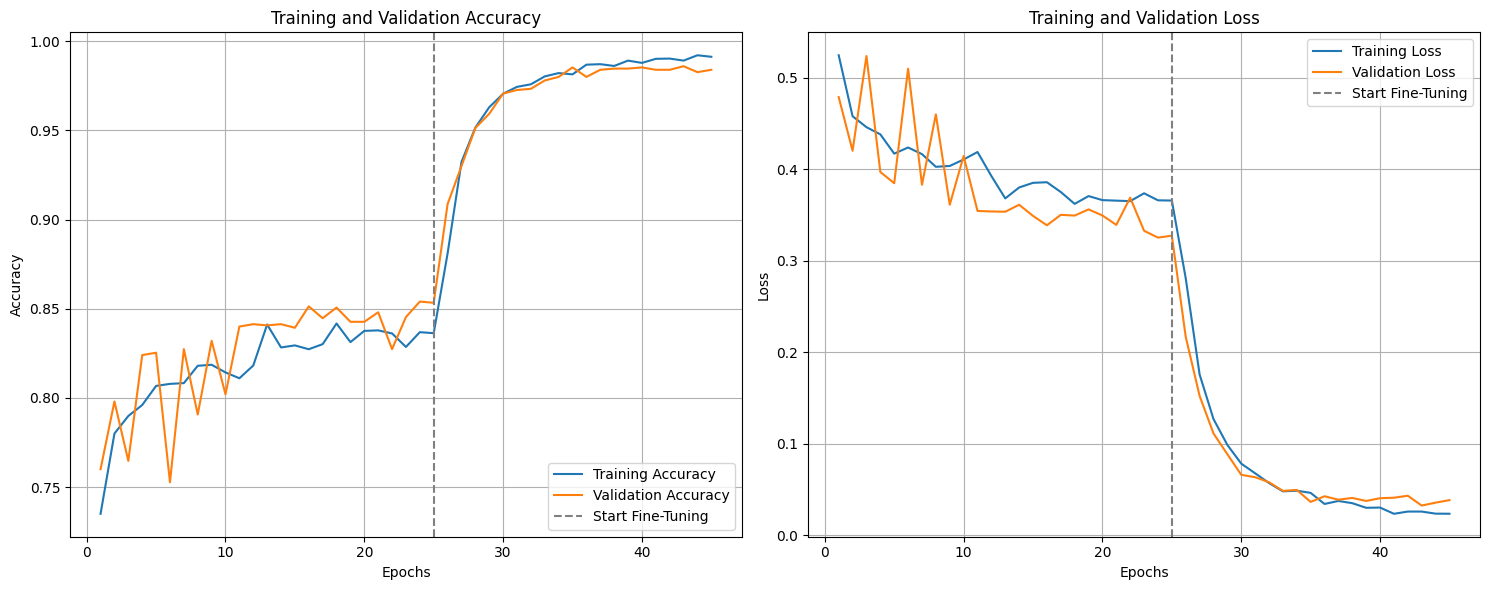

In [12]:
# ---  Learning Curve ---
def plot_learning_curves(history, phase1_epochs):
    acc = history['train_acc']
    val_acc = history['val_acc']
    loss = history['train_loss']
    val_loss = history['val_loss']
    
    epochs_range = range(1, len(acc) + 1)

    plt.figure(figsize=(15, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    
    plt.axvline(x=phase1_epochs, color='gray', linestyle='--', label='Start Fine-Tuning')
    
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.grid(True)


    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    

    plt.axvline(x=phase1_epochs, color='gray', linestyle='--', label='Start Fine-Tuning')
    
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.grid(True)

    plt.tight_layout()
    plt.show()


plot_learning_curves(history, phase1_epochs=EPOCH)


--- Final Testing & Metrics Calculation ---


Testing: 100%|██████████| 47/47 [00:23<00:00,  2.02it/s]


 Final Results
Accuracy  : 0.9907
Precision : 0.9920
Recall    : 0.9893
F1 Score  : 0.9907
------------------------------

 Report 
              precision    recall  f1-score   support

      Normal       0.99      0.99      0.99       750
         SCC       0.99      0.99      0.99       750

    accuracy                           0.99      1500
   macro avg       0.99      0.99      0.99      1500
weighted avg       0.99      0.99      0.99      1500



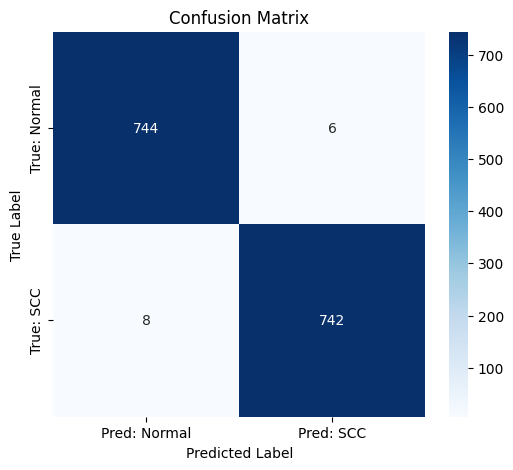

In [13]:
print("\n--- Final Testing & Metrics Calculation ---")

model.load_state_dict(torch.load(best_model_path))

model.eval()
model.to(device)


all_labels = []
all_preds = []


with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Testing"):
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())


accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='binary')
recall = recall_score(all_labels, all_preds, average='binary')
f1 = f1_score(all_labels, all_preds, average='binary')

print("\n" + "="*30)
print(f" Final Results")
print("="*30)
print(f"Accuracy  : {accuracy:.4f}")
print(f"Precision : {precision:.4f}")
print(f"Recall    : {recall:.4f}")
print(f"F1 Score  : {f1:.4f}")
print("-" * 30)


print("\n Report ")
print(classification_report(all_labels, all_preds, target_names=['Normal', 'SCC']))


cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Pred: Normal', 'Pred: SCC'],
            yticklabels=['True: Normal', 'True: SCC'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()